To Do:
- Do a round of fine-tuning of the entire model


Using example from the following website:
https://keras.io/examples/vision/image_classification_from_scratch/

In [15]:
pip install Pillow

In [1]:
#First we load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
#from keras import layers
import matplotlib.pyplot as plt
import tensorflow
import sklearn
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

image_location = r'\Users\isa_s\OneDrive\Dokumente\Uni\Leuven\2. semester\advanced analytics\2. assignment\images\images'

Trial 2, I think that we need to instead use Image data loading as explained here : https://keras.io/api/data_loading/image/
(so using keras.utils.image_dataset_from_directory)
https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/ 

In [2]:
# Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)
data1 = pd.DataFrame(data)


# Select 10% of the games
num_selected_games = int(len(data1) * 0.1)
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)
#print(selected_games) # selected 1468 games



# Extract game IDs and prices
game_ids = []
prices = []
for index, game in selected_games.iterrows():
    game_ids.append(game['appid'])
    prices.append(game['price'])

In [5]:
# Split data into training and validation sets based on games
#train_game_ids, test_game_ids, train_prices, test_prices = train_test_split(game_ids, prices, test_size=0.2, random_state=42)
#print(train_game_ids[:10])
train_games, test_games = train_test_split(selected_games, test_size=0.2, random_state=42)
print(train_games[:10])

         appid     release                                            title  \
628    2672850  2024-02-13                   A Game About Flicking A Switch   
6196   2536310  2023-10-02               The Legend of Ogorets #2: Tsundere   
6071   2278630  2023-10-05  Livestream 2: Escape from Togaezuka Happy Place   
14686  2839310  2024-03-11                                           Evader   
1543   2779390  2024-03-01                                     Bolt'N'Punch   
952    1358510  2024-02-02                                Snake In The Cube   
13918  2116970  2023-01-31                                       StarStruck   
6053   2554950  2023-10-06                                            Raioh   
5061   2574820  2023-10-31                                     BENDERMAN VR   
8300   2467210  2023-08-01                            Chinese Chess-Wargame   

       price      sentiment reviews percentage  \
628      299          Mixed      20         65   
6196     499           None   

In [27]:
# Create a list of dictionaries for DataFrame
#adding 25 pictures per game, either adding the same images again or limiting the number of images 
train_data = []
nr_images_per_game = []
number = 25
for index, game in train_games.iterrows():
    nr_images = 0
    nr_images = 0
    while nr_images < number:
        for screenshot in game['screenshots']:
            if nr_images >= number:
                break
            nr_images += 1
            train_data.append({'screenshot': screenshot, 'price': game['price']})
    nr_images_per_game.append(nr_images)
    

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Display the DataFrame
print(train_label_df)


# Do the same for the test set
# Create a list of dictionaries for DataFrame
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
test_label_df = pd.DataFrame(test_data)

# Display the DataFrame
print(test_label_df)

                                              screenshot  price
0      2672850_ss_3163a144b92c0fa26f1afcc67589f809067...    299
1      2672850_ss_5896f91cf99b05b9062938eb68d8613cd91...    299
2      2672850_ss_6cbeb821c7c2d2b74b5946439a163d98360...    299
3      2672850_ss_d709f67922e49c47df64348c01c1593512f...    299
4      2672850_ss_dd9f8786dc502e82c98e52c25cebaaad4ef...    299
...                                                  ...    ...
29345  2709060_ss_f7f2e29f1130910d4250ef821ebc58c2b51...    975
29346  2709060_ss_09726ebe1ecf72d3bb526e6e8cc255c202f...    975
29347  2709060_ss_80029d27fc7f997cf9b8d77ee9dbb9473fb...    975
29348  2709060_ss_90ed1af61963ebeabc0e8a0989691629672...    975
29349  2709060_ss_92ca93a9d8da3b094f6b87896a4a75672c6...    975

[29350 rows x 2 columns]
                                             screenshot  price
0     1841820_ss_46723f7f342789b32786efe3edfa22f8ddf...    689
1     1841820_ss_48dff1cccfc2ffda0db83e7804fc0359c33...    689
2     1841820_ss_

In [29]:
nr_images_per_game.sort(reverse=True)
sum(nr_images_per_game)/len(nr_images_per_game)

25.0

With Keras 2.2.4 you can use flow_from_dataframe which solves what you want to do, allowing you to flow images from a directory for regression problems. You should store all your images in a folder and load a dataframe containing in one column the image IDs and in the other column the regression score (labels) and set class_mode='other' in flow_from_dataframe.

Here you can find an example where the images are in image_dir, the dataframe with the image IDs and the regression scores is loaded with pandas from the "train file"

Potentially add , horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   rotation_range=30) 
to image generator.

In [30]:
#take out data augmentation so that we make sure we have the same amount of images per game
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = .2)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(360, 640), 
                                              batch_size=50, subset='training')

val_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(360, 640), 
                                              batch_size=50, subset='validation')

# for the test set
test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = .2) 
# here we don't perform any transormations

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(360, 640), 
                                              batch_size=50)


Found 23480 validated image filenames.
Found 5870 validated image filenames.
Found 2586 validated image filenames.


Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [36]:
from tensorflow.keras.applications import VGG16
base_model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(360, 640, 3))

In [42]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape, SimpleRNN
from tensorflow.keras.models import Sequential

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # feature_dimension depends on the output shape of GlobalAveragePooling2D
    #Reshape((25, 360, 640)),  # Reshape to (batch_size, timesteps, input_dim)
    SimpleRNN(64, return_sequences=False),  # Add SimpleRNN layer with 64 units
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
print("Model is compiled")

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)
print("Model is trained")


# Evaluate model
loss, mae = model.evaluate(test_generator)
print("Validation Mean Absolute Error:", mae)

print("Model is evaluated")

Model is compiled


ValueError: Input 0 of layer "simple_rnn_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [11]:
base_model.summary()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,069 (56.89 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,588 (514.02 KB)

Give the predicted price for a game


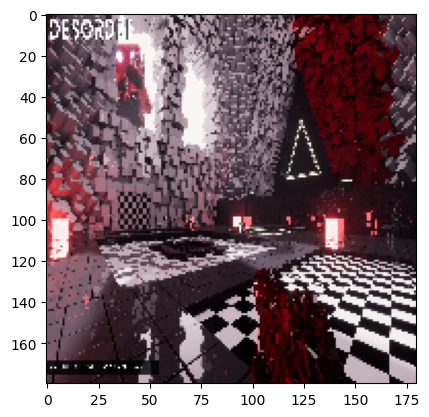

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[2463.739]]


In [13]:
number = 3
filename = test_label_df.loc[number, "screenshot"]
# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(180, 180))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])



_________________________________________________________________________________________________________________________

Unfreezing the model

In [14]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ vgg16 (Functional)          │ (None, 5, 5, 512)     │ 14,714,688 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 128)           │     65,664 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,912,069 (56.89 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 131,588 (514.02 KB)

Fitting the end-to-end model
165/165 ━━━━━━━━━━━━━━━━━━━━ 8988s 54s/step - binary_accuracy: 0.0000e+00 - loss: -183056924672.0000 - val_binary_accuracy: 0.0000e+00 - val_loss: -30351680339968.0000


In [17]:
base_model.summary()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,341,445 (169.15 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,560,964 (112.77 MB)

In [15]:
# Evaluate model
loss, mae = model.evaluate(test_generator)
print("Validation Mean Absolute Error:", mae)

print("Model is evaluated")

52/52 ━━━━━━━━━━━━━━━━━━━━ 585s 11s/step - binary_accuracy: 0.0000e+00 - loss: -21885746151424.0000
Validation Mean Absolute Error: 0.0
Model is evaluated


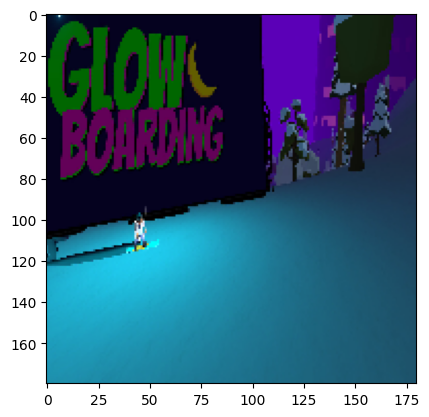

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
[[1.655664e+12]]
689


In [19]:
number = 3
filename = test_label_df.loc[number, "screenshot"]
# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(180, 180))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])

Unfreezing only top layers

In [15]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(360, 640, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

print("stp 1 done")
# Freeze the base_model
base_model.trainable = False
#Create new model on top
inputs = keras.Input(shape=(360, 640, 3))
print("step 2 done")
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

stp 1 done
step 2 done


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 360, 640, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 360, 640, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 12, 20, 2048)  │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error],
)
print("model compiled")
epochs = 1
print("Fitting the top layer of the model")
model.fit(train_generator, epochs=epochs, validation_data=val_generator)

model compiled
Fitting the top layer of the model


c:\Users\isa_s\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 9082s 54s/step - loss: 111708992.0000 - mean_squared_error: 111853232.0000 - val_loss: 19522302.0000 - val_mean_squared_error: 19855436.0000


In [19]:
# Evaluate model
loss, mse = model.evaluate(test_generator)
print("Validation Mean Absolute Error:", mse)

print("Model is evaluated")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1819s 34s/step - loss: 3137849.2500 - mean_squared_error: 3137710.0000
Validation Mean Absolute Error: 2488731.5
Model is evaluated


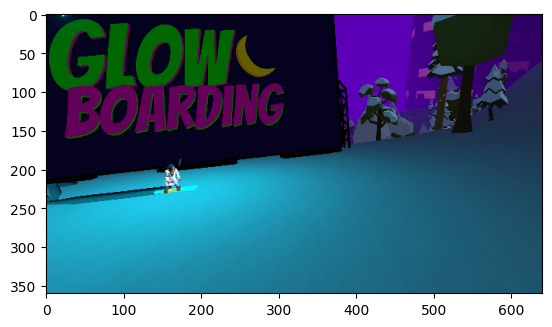

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
[[14.997453]]
689


In [20]:
number = 3
filename = test_label_df.loc[number, "screenshot"]
# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(360, 640))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(test_label_df.loc[number, "price"])